In [1]:
import pickle
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score


In [2]:
#define pickle paths
model_pathLRGPT = '../pickle/LogisticRegression/gpt35_model.pkl'
model_pathRFGPT = '../pickle/RandomForest/gpt35_model.pkl'
model_pathSVMGPT = '../pickle/LogisticRegression/gpt35_model.pkl'

model_pathLRNeo = '../pickle/LogisticRegression/gptNeo_model.pkl'
model_pathRFNeo = '../pickle/RandomForest/gptNeo_model.pkl'
model_pathSVMNeo = '../pickle/LogisticRegression/gptNeo_model.pkl'

In [3]:
dataNeo = pd.read_csv('../../preprocessing/StorePreprocessed/GPTNeocsv.csv')
X_trainNeo, X_testNeo, y_trainNeo, y_testNeo = train_test_split(dataNeo["text"], dataNeo["label"], test_size=0.2, random_state=42, stratify=dataNeo["label"])
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)
X_trainNeo = X_trainNeo.dropna()
X_testNeo = X_testNeo.dropna()
y_trainNeo = y_trainNeo[X_trainNeo.index]
y_testNeo = y_testNeo[X_testNeo.index]
X_trainNeo = vectorizer.fit_transform(X_trainNeo)
X_testNeo = vectorizer.transform(X_testNeo)

In [4]:
dataGPT = pd.read_csv('../../preprocessing/StorePreprocessed/GPT35csv.csv')
X_trainGPT, X_testGPT, y_trainGPT, y_testGPT = train_test_split(dataGPT["text"], dataGPT["label"], test_size=0.2, random_state=42, stratify=dataGPT["label"])
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(4, 4), max_features=11000)
X_trainGPT = X_trainGPT.dropna()
X_testGPT = X_testGPT.dropna()
y_trainGPT = y_trainGPT[X_trainGPT.index]
y_testGPT = y_testGPT[X_testGPT.index]
X_trainGPT = vectorizer.fit_transform(X_trainGPT)
X_testGPT = vectorizer.transform(X_testGPT)

In [5]:
#load individual pickle-models
if os.path.exists(model_pathLRGPT) and os.path.exists(model_pathRFGPT) and os.path.exists(model_pathSVMGPT) and os.path.exists(model_pathLRNeo) and os.path.exists(model_pathRFNeo) and os.path.exists(model_pathSVMNeo):

    with open(model_pathLRGPT, 'rb') as lr:
        lr_bestGPT = pickle.load(lr)
    with open(model_pathRFGPT, 'rb') as rf:
        rf_bestGPT = pickle.load(rf)
    with open(model_pathSVMGPT, 'rb') as svm:
        svm_bestGPT = pickle.load(svm)
    
    with open(model_pathLRNeo, 'rb') as lr:
        lr_bestNeo = pickle.load(lr)
    with open(model_pathRFNeo, 'rb') as rf:
        rf_bestNeo = pickle.load(rf)
    with open(model_pathSVMNeo, 'rb') as svm:
        svm_bestNeo = pickle.load(svm)

else:
    print('Model not found')
    exit(1)

/Users/romanoelfken/miniconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
y_pred_svmGPT = svm_bestGPT.predict(X_testGPT)

y_pred_lrGPT = lr_bestGPT.predict(X_testGPT)

y_pred_rfGPT = rf_bestGPT.predict(X_testGPT)

In [7]:
y_pred_svmNeo = svm_bestNeo.predict(X_testNeo)

y_pred_lrNeo = lr_bestNeo.predict(X_testNeo)

y_pred_rfNeo = rf_bestNeo.predict(X_testNeo)

In [8]:
predictionsGPT = np.array([y_pred_rfGPT, y_pred_lrGPT, y_pred_svmGPT])
y_pred_combinedGPT = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictionsGPT)

predictionsNeo = np.array([y_pred_rfNeo, y_pred_lrNeo, y_pred_svmNeo])
y_pred_combinedNeo = (y_pred_svmNeo & y_pred_lrNeo & y_pred_rfNeo)

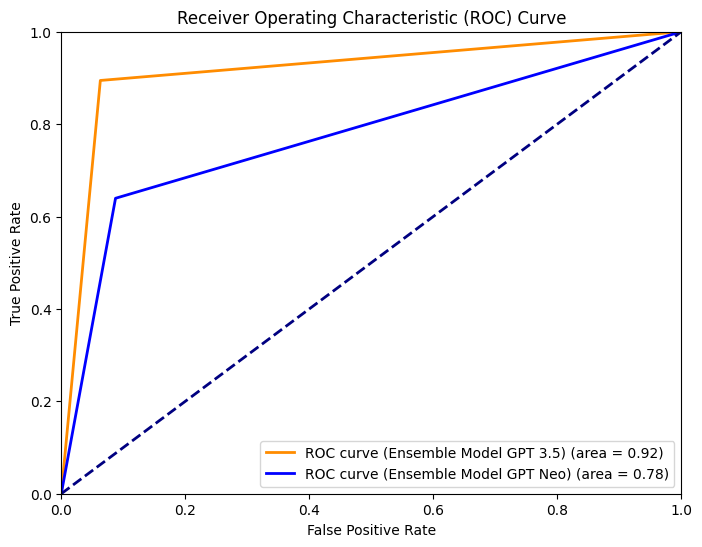

Combined Model AUC (GPT): 0.92
Combined Model AUC (Neo): 0.78


In [9]:
# GPT
fprGPT, tprGPT, thresholdsGPT = roc_curve(y_testGPT, y_pred_combinedGPT)
roc_aucGPT = roc_auc_score(y_testGPT, y_pred_combinedGPT)
# Neo
fprNeo, tprNeo, thresholdsNeo = roc_curve(y_testNeo, y_pred_combinedNeo)
roc_aucNeo = roc_auc_score(y_testNeo, y_pred_combinedNeo)


plt.figure(figsize=(8, 6))

plt.plot(fprGPT, tprGPT, color='darkorange', lw=2, label=f'ROC curve (Ensemble Model GPT 3.5) (area = {roc_aucGPT:.2f})')
plt.plot(fprNeo, tprNeo, color='blue', lw=2, label=f'ROC curve (Ensemble Model GPT Neo) (area = {roc_aucNeo:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('../../evaluation/GPT35_Evaluation/ROC_Curve_EnsembleGPTNeo.png')
plt.show()

print(f"Combined Model AUC (GPT): {roc_aucGPT:.2f}")
print(f"Combined Model AUC (Neo): {roc_aucNeo:.2f}")